### Setup Environment:

In [1]:
from src.embeddings import load_data, split_dataset, train_and_evaluate_model_nn

# Class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import os
import torch

2024-02-22 20:07:31.435498: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 20:07:31.479727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 20:07:31.479766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 20:07:31.481144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 20:07:31.489586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

## Evaluate the Embeddings

In [2]:
def run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, NORMAL=False, DR_ICDR_3=False, quality=False, oversample=False):
    
    # Get the dataset
    if quality:
        X_quality, y_quality, X_bad_quality, y_bad_quality = load_data(labels_path=LABELS_PATH, backbone=EMBEDDINGS_BACKBONE, label=LABEL, directory=EMBEDDINGS_DIR, normal=NORMAL, DR_ICDR_3=DR_ICDR_3, quality=quality)
    else:    
        X, y = load_data(labels_path=LABELS_PATH, backbone=EMBEDDINGS_BACKBONE, label=LABEL, directory=EMBEDDINGS_DIR, normal=NORMAL, DR_ICDR_3=DR_ICDR_3, quality=quality)
        
    if quality:
        X_train_quality, X_test_quality, y_train_quality, y_test_quality = split_dataset(X_quality, y_quality, test_size=TEST_SIZE, oversample=oversample)
        X_train_bad_quality, X_test_bad_quality, y_train_bad_quality, y_test_bad_quality = split_dataset(X_bad_quality, y_bad_quality, test_size=TEST_SIZE, oversample=oversample)

        X_train = np.concatenate((X_train_quality, X_train_bad_quality))
        y_train = np.concatenate((y_train_quality, y_train_bad_quality))
        
    else:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=TEST_SIZE, oversample=oversample)
    
    num_classes = len(np.unique(y_train))
    input_dim = X_train.shape[1]  # Number of features
    
    if quality:
        # Train and evaluate with good and bad quality subsets
        print('#'*50, ' GOOD QUALITY ', '#'*50)
        # Define a list of models to test
        if CLASS_WEIGTHS:
            # Compute class weights using class indices
            class_weights = compute_class_weight('balanced', classes=np.unique(y_train_quality), y=y_train_quality)
            class_weights = torch.tensor(class_weights, dtype=torch.float32)
            print(f'Setting class weigths to: {class_weights}')

        # Run the experiments
        print('#'*50, ' Train all evaluate good quality ', '#'*50)
        model, results = train_and_evaluate_model_nn(X_train, X_test_quality, y_train, y_test_quality, input_dim, num_classes, class_weights=class_weights)
        
        print('#'*50, ' Train all evaluate bad quality ', '#'*50)
        model, results = train_and_evaluate_model_nn(X_train, X_test_bad_quality, y_train, y_test_bad_quality, input_dim, num_classes, class_weights=class_weights)        
        return model
        
    else:
        # Define a list of models to test
        if CLASS_WEIGTHS:
            # class indices from y labels
            # Compute class weights using class indices
            class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
            class_weights = torch.tensor(class_weights, dtype=torch.float32)
            print(f'Setting class weigths to: {class_weights}')

        # Run the experiments
        model, results = train_and_evaluate_model_nn(X_train, X_test, y_train, y_test, input_dim, num_classes, class_weights=class_weights)        
    
        return model

#### Constants

In [3]:

# Constants:
LABELS_PATH = '/home/opc/Retina/BRSET/labels.csv'
EMBEDDINGS_BACKBONE = None
EMBEDDINGS_DIR = 'Embeddings'
TEST_SIZE = 0.3
CLASS_WEIGTHS = True
quality = False
oversample=False

### Sex Prediction

Training set size is: 11386 rows and 1024 columns
Test set size is: 4880 rows and 1024 columns


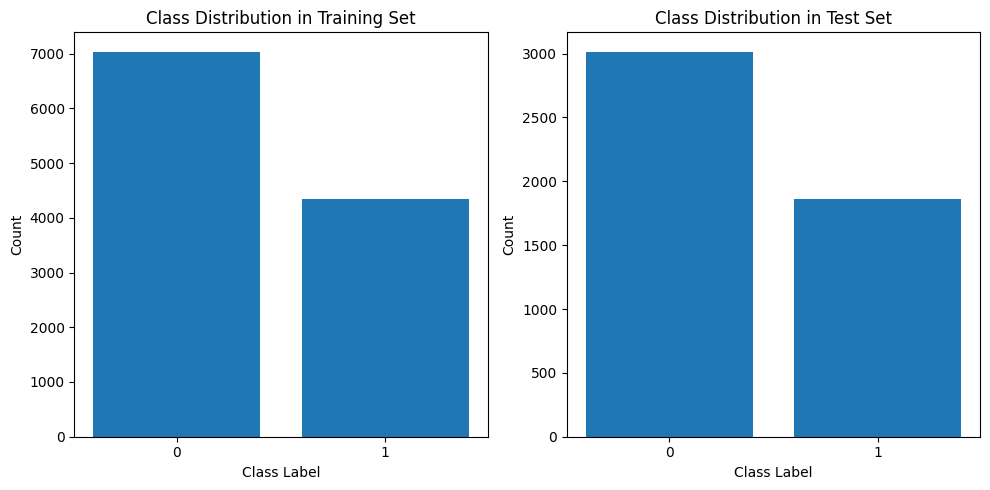

Setting class weigths to: tensor([0.8091, 1.3088])
Epoch 1, Loss: 0.7001075148582458
Epoch 2, Loss: 0.7023558020591736
Epoch 3, Loss: 0.6910095810890198
Epoch 4, Loss: 0.6847343444824219
Epoch 5, Loss: 0.6949136853218079
Epoch 6, Loss: 0.6916490197181702
Epoch 7, Loss: 0.6821385025978088
Epoch 8, Loss: 0.6979637145996094
Epoch 9, Loss: 0.685643196105957
Epoch 10, Loss: 0.6739634275436401
Epoch 11, Loss: 0.685528039932251
Epoch 12, Loss: 0.6841871738433838
Epoch 13, Loss: 0.6961298584938049
Epoch 14, Loss: 0.6861124038696289
Epoch 15, Loss: 0.676643967628479
Epoch 16, Loss: 0.6905494928359985
Epoch 17, Loss: 0.6978120803833008
Epoch 18, Loss: 0.6880495548248291
Epoch 19, Loss: 0.7031362652778625
Epoch 20, Loss: 0.6867445111274719
Finished Training


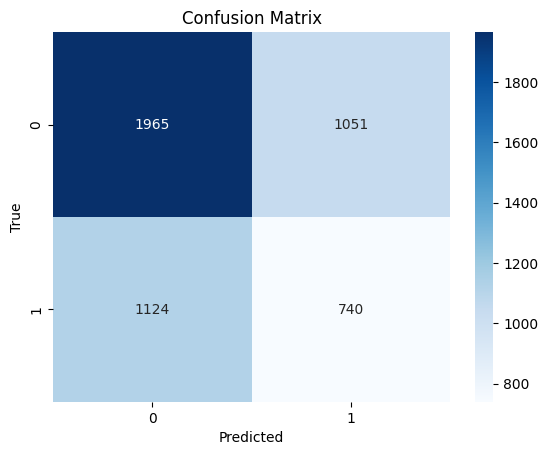

              precision    recall  f1-score   support

           0       0.64      0.65      0.64      3016
           1       0.41      0.40      0.40      1864

    accuracy                           0.55      4880
   macro avg       0.52      0.52      0.52      4880
weighted avg       0.55      0.55      0.55      4880



In [4]:
LABEL = 'patient_sex'

model = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, quality=quality, oversample=oversample)

## Diabetic Retinopathy

### 5 Class

Training set size is: 11386 rows and 1024 columns
Test set size is: 4880 rows and 1024 columns


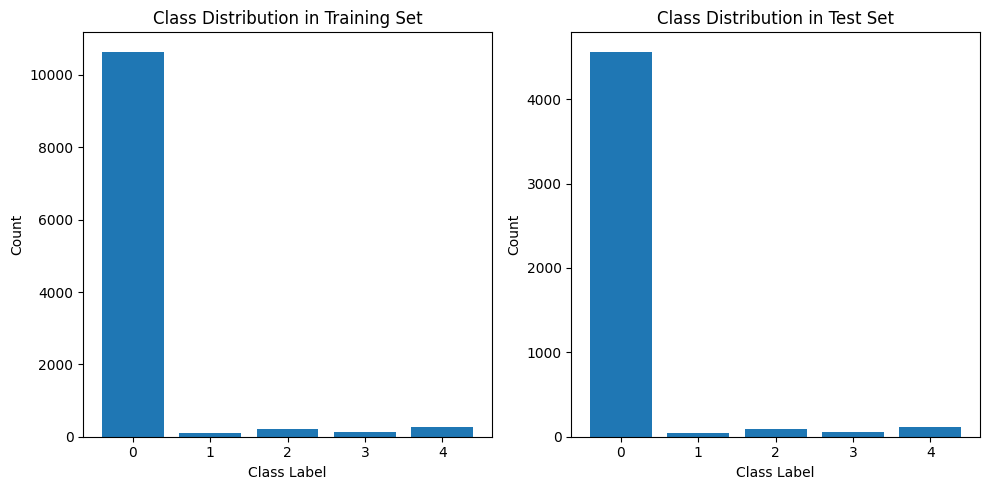

Setting class weigths to: tensor([ 0.2139, 20.0815, 10.4942, 17.1221,  8.2569])
Epoch 1, Loss: 1.5525673627853394
Epoch 2, Loss: 1.3493658304214478
Epoch 3, Loss: 1.3860236406326294
Epoch 4, Loss: 1.9155046939849854
Epoch 5, Loss: 1.6420034170150757
Epoch 6, Loss: 1.3914915323257446
Epoch 7, Loss: 1.954545497894287
Epoch 8, Loss: 1.5734994411468506
Epoch 9, Loss: 1.3258113861083984
Epoch 10, Loss: 1.2052093744277954
Epoch 11, Loss: 1.4246668815612793
Epoch 12, Loss: 1.4364084005355835
Epoch 13, Loss: 1.5616486072540283
Epoch 14, Loss: 1.3242439031600952
Epoch 15, Loss: 1.4332917928695679
Epoch 16, Loss: 1.478268027305603
Epoch 17, Loss: 1.4021403789520264
Epoch 18, Loss: 1.363269567489624
Epoch 19, Loss: 1.5802266597747803
Epoch 20, Loss: 1.1720516681671143
Finished Training


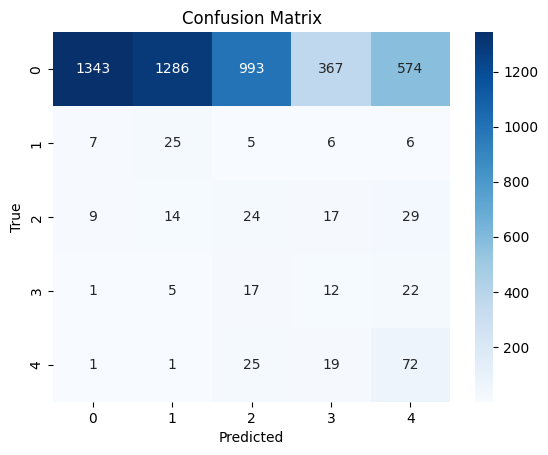

              precision    recall  f1-score   support

           0       0.99      0.29      0.45      4563
           1       0.02      0.51      0.04        49
           2       0.02      0.26      0.04        93
           3       0.03      0.21      0.05        57
           4       0.10      0.61      0.18       118

    accuracy                           0.30      4880
   macro avg       0.23      0.38      0.15      4880
weighted avg       0.93      0.30      0.43      4880



In [5]:
LABEL = 'DR_ICDR'
DR_ICDR_3 = False

model = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, DR_ICDR_3=DR_ICDR_3, quality=quality, oversample=oversample)

### 3 Class

Training set size is: 11386 rows and 1024 columns
Test set size is: 4880 rows and 1024 columns


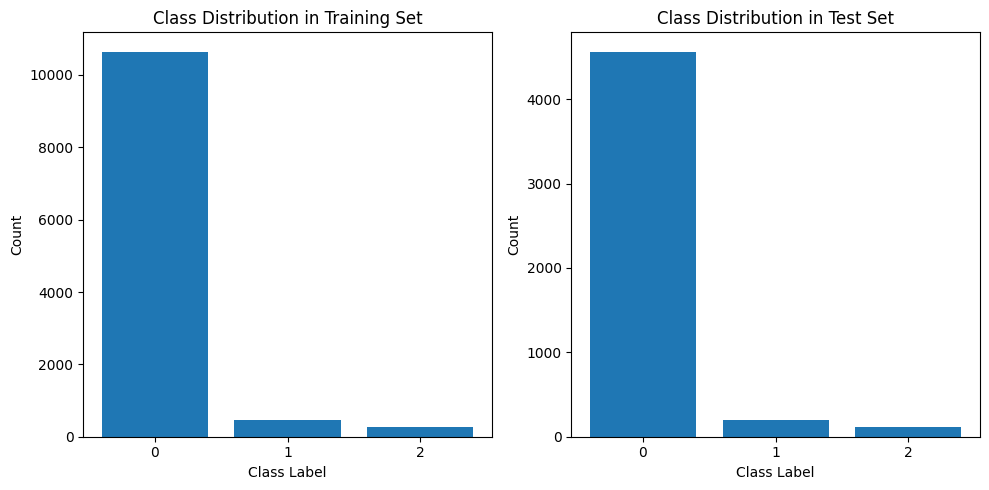

Setting class weigths to: tensor([ 0.3565,  8.1903, 13.7614])
Epoch 1, Loss: 0.889458179473877
Epoch 2, Loss: 0.9584094285964966
Epoch 3, Loss: 0.9445035457611084
Epoch 4, Loss: 0.9735243916511536
Epoch 5, Loss: 0.884712815284729
Epoch 6, Loss: 0.8215738534927368
Epoch 7, Loss: 0.7849680185317993
Epoch 8, Loss: 0.821890652179718
Epoch 9, Loss: 1.0589268207550049
Epoch 10, Loss: 0.7324877977371216
Epoch 11, Loss: 0.8424106240272522
Epoch 12, Loss: 0.806612491607666
Epoch 13, Loss: 1.0456417798995972
Epoch 14, Loss: 0.8309714198112488
Epoch 15, Loss: 1.2520060539245605
Epoch 16, Loss: 1.0328072309494019
Epoch 17, Loss: 0.8262785077095032
Epoch 18, Loss: 0.8082177042961121
Epoch 19, Loss: 0.8343351483345032
Epoch 20, Loss: 0.7917397618293762
Finished Training


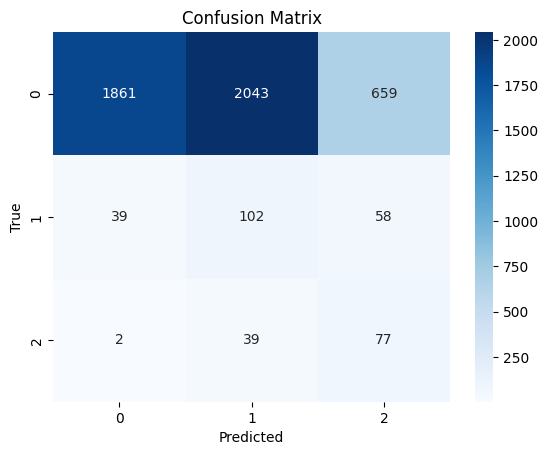

              precision    recall  f1-score   support

           0       0.98      0.41      0.58      4563
           1       0.05      0.51      0.09       199
           2       0.10      0.65      0.17       118

    accuracy                           0.42      4880
   macro avg       0.37      0.52      0.28      4880
weighted avg       0.92      0.42      0.55      4880



In [6]:
LABEL = 'DR_ICDR'
DR_ICDR_3= True

model = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, DR_ICDR_3=DR_ICDR_3, quality=quality, oversample=oversample)

### 2 Class

Training set size is: 11386 rows and 1024 columns
Test set size is: 4880 rows and 1024 columns


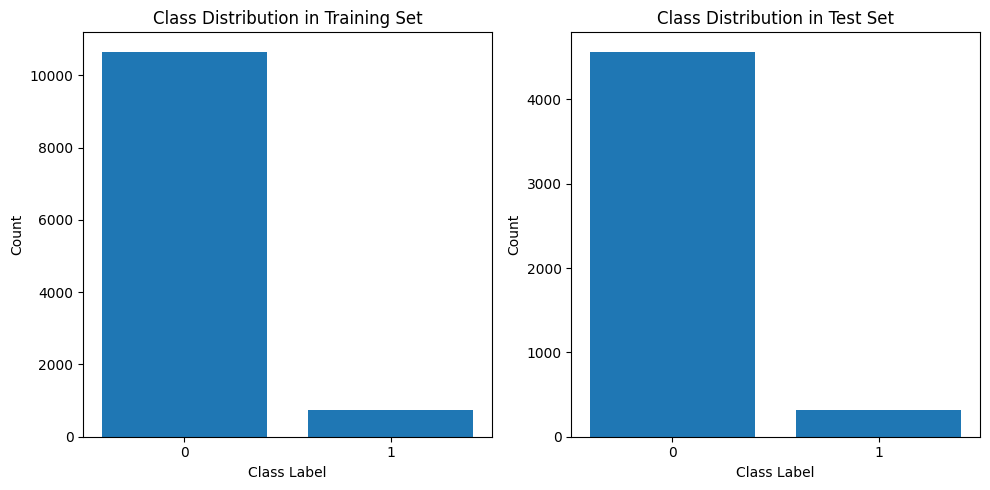

Setting class weigths to: tensor([0.5344, 7.7753])
Epoch 1, Loss: 0.5361375212669373
Epoch 2, Loss: 0.698386549949646
Epoch 3, Loss: 0.6389008164405823
Epoch 4, Loss: 0.50804603099823
Epoch 5, Loss: 0.43871861696243286
Epoch 6, Loss: 0.6570777893066406
Epoch 7, Loss: 0.7220364212989807
Epoch 8, Loss: 0.6346369385719299
Epoch 9, Loss: 0.5488001108169556
Epoch 10, Loss: 0.47018852829933167
Epoch 11, Loss: 0.6491051912307739
Epoch 12, Loss: 0.5077101588249207
Epoch 13, Loss: 0.6122816801071167
Epoch 14, Loss: 0.5655162334442139
Epoch 15, Loss: 0.6768161654472351
Epoch 16, Loss: 0.5195670127868652
Epoch 17, Loss: 0.4998018145561218
Epoch 18, Loss: 0.6528822183609009
Epoch 19, Loss: 0.5677765607833862
Epoch 20, Loss: 0.6520044207572937
Finished Training


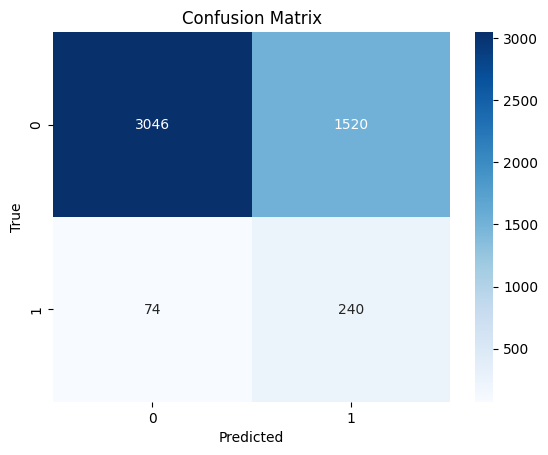

              precision    recall  f1-score   support

           0       0.98      0.67      0.79      4566
           1       0.14      0.76      0.23       314

    accuracy                           0.67      4880
   macro avg       0.56      0.72      0.51      4880
weighted avg       0.92      0.67      0.76      4880



In [7]:
LABEL = 'diabetic_retinopathy'

model = run_experiments(LABELS_PATH, LABEL, EMBEDDINGS_BACKBONE, EMBEDDINGS_DIR, TEST_SIZE, CLASS_WEIGTHS, quality=quality, oversample=oversample)